In [3]:
from spark_session_manager import SparkSessionManager

# Get the Spark session
spark = SparkSessionManager.get_spark_session()

# Read the data
df = spark.read.parquet("data/processed/tranformed_US_youtube_trending_data.parquet")


## Engagement metrics

a lot of values in column dislikes are '0', thus eng. metrics will not use it

- view_to_like_ratio = view_count / likes
- like_to_comment_ratio = likes / comment_count
- engagement_rate = ((likes + comment_count) / view_count) * 100
- comments_per_view = comment_count / view_count

In [4]:
# introduce engagement metrics

from pyspark.sql import functions as F


In [5]:
df = df.withColumn("view_to_like_ratio", F.col("view_count") / F.col("likes")) \
    .withColumn("like_to_comment_ratio", F.col("likes") / F.col("comment_count")) \
    .withColumn("engagement_rate", ((F.col("likes") + F.col("comment_count")) / F.col("view_count")) * 100) \
    .withColumn("comments_per_view", F.col("comment_count") / F.col("view_count")) \
    .withColumn("average_views_per_day", F.col("view_count") / F.datediff(F.col("trending_date"), F.col("publishedAt")))


In [9]:
# calculate avg, median, min, max, std for each metric for each category

eng_metrics_by_category = df.groupBy("categoryTitle").agg(
    F.avg("view_to_like_ratio").alias("avg_view_to_like_ratio"),
    F.avg("like_to_comment_ratio").alias("avg_like_to_comment_ratio"),
    F.avg("engagement_rate").alias("avg_engagement_rate"),
    F.avg("comments_per_view").alias("avg_comments_per_view"),
    F.avg("average_views_per_day").alias("avg_average_views_per_day"),
    F.stddev("view_to_like_ratio").alias("stddev_view_to_like_ratio"),
    F.stddev("like_to_comment_ratio").alias("stddev_like_to_comment_ratio"),
    F.stddev("engagement_rate").alias("stddev_engagement_rate"),
    F.stddev("comments_per_view").alias("stddev_comments_per_view"),
    F.stddev("average_views_per_day").alias("stddev_average_views_per_day"),
    F.min("view_to_like_ratio").alias("min_view_to_like_ratio"),
    F.min("like_to_comment_ratio").alias("min_like_to_comment_ratio"),
    F.min("engagement_rate").alias("min_engagement_rate"),
    F.min("comments_per_view").alias("min_comments_per_view"),
    F.min("average_views_per_day").alias("min_average_views_per_day"),
    F.max("view_to_like_ratio").alias("max_view_to_like_ratio"),
    F.max("like_to_comment_ratio").alias("max_like_to_comment_ratio"),
    F.max("engagement_rate").alias("max_engagement_rate"),
    F.max("comments_per_view").alias("max_comments_per_view"),
    F.max("average_views_per_day").alias("max_average_views_per_day"),
    F.expr("percentile_approx(view_to_like_ratio, 0.5)").alias("median_view_to_like_ratio"),
    F.expr("percentile_approx(like_to_comment_ratio, 0.5)").alias("median_like_to_comment_ratio"),
    F.expr("percentile_approx(engagement_rate, 0.5)").alias("median_engagement_rate"),
    F.expr("percentile_approx(comments_per_view, 0.5)").alias("median_comments_per_view"),
    F.expr("percentile_approx(average_views_per_day, 0.5)").alias("median_average_views_per_day")
)

In [11]:
# show the dataframe
eng_metrics_by_category.show()

+--------------------+----------------------+-------------------------+-------------------+---------------------+-------------------------+-------------------------+----------------------------+----------------------+------------------------+----------------------------+----------------------+-------------------------+-------------------+---------------------+-------------------------+----------------------+-------------------------+-------------------+---------------------+-------------------------+-------------------------+----------------------------+----------------------+------------------------+----------------------------+
|       categoryTitle|avg_view_to_like_ratio|avg_like_to_comment_ratio|avg_engagement_rate|avg_comments_per_view|avg_average_views_per_day|stddev_view_to_like_ratio|stddev_like_to_comment_ratio|stddev_engagement_rate|stddev_comments_per_view|stddev_average_views_per_day|min_view_to_like_ratio|min_like_to_comment_ratio|min_engagement_rate|min_comments_per_view|

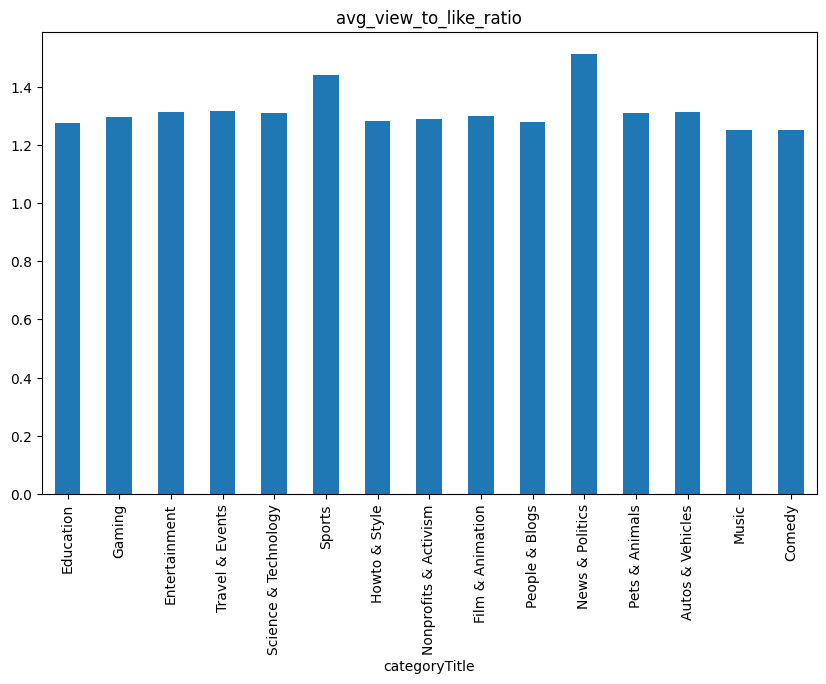

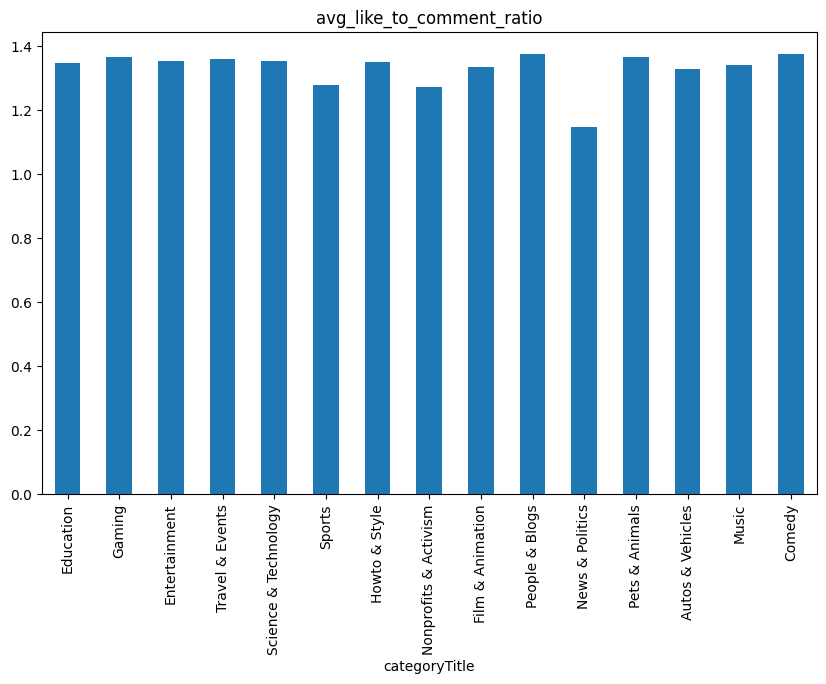

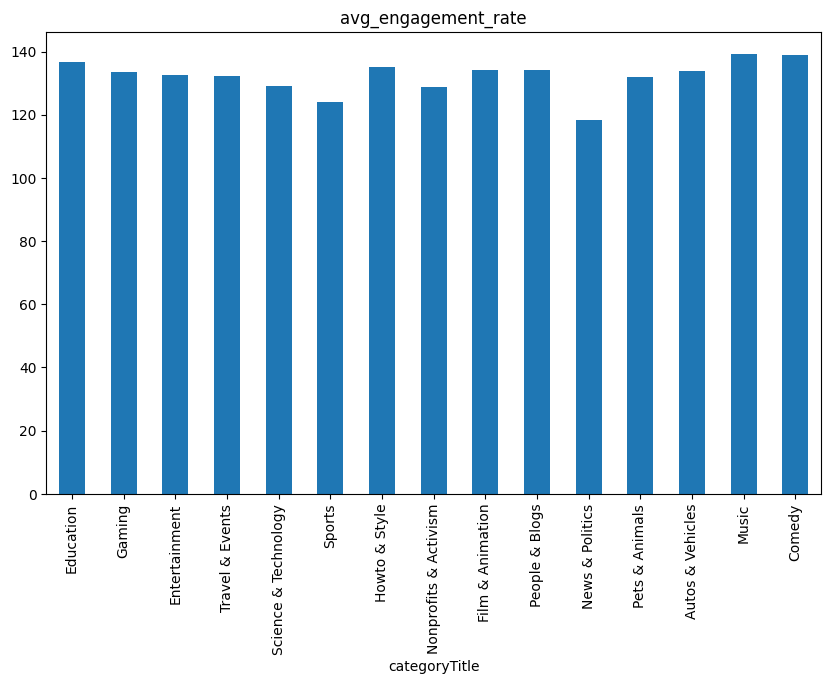

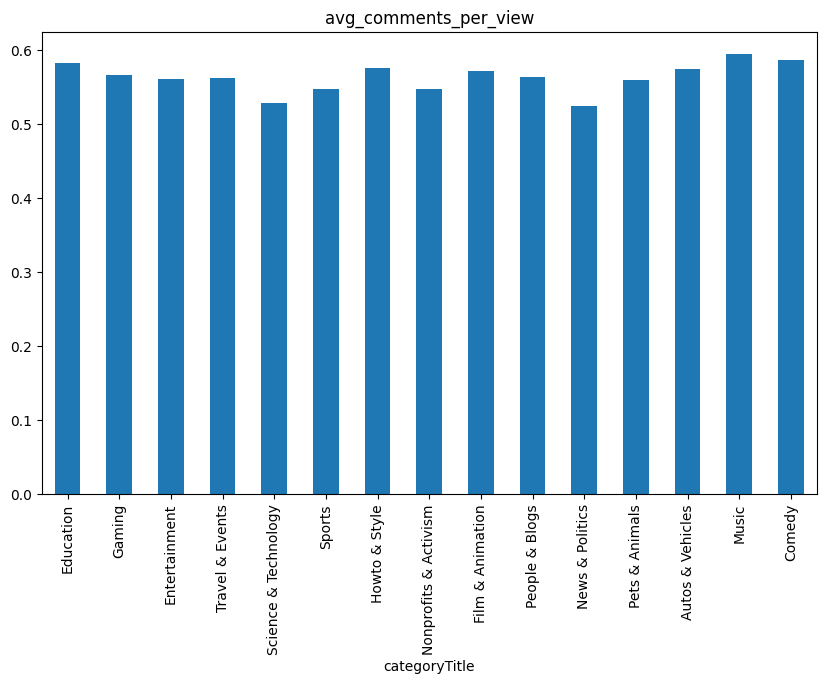

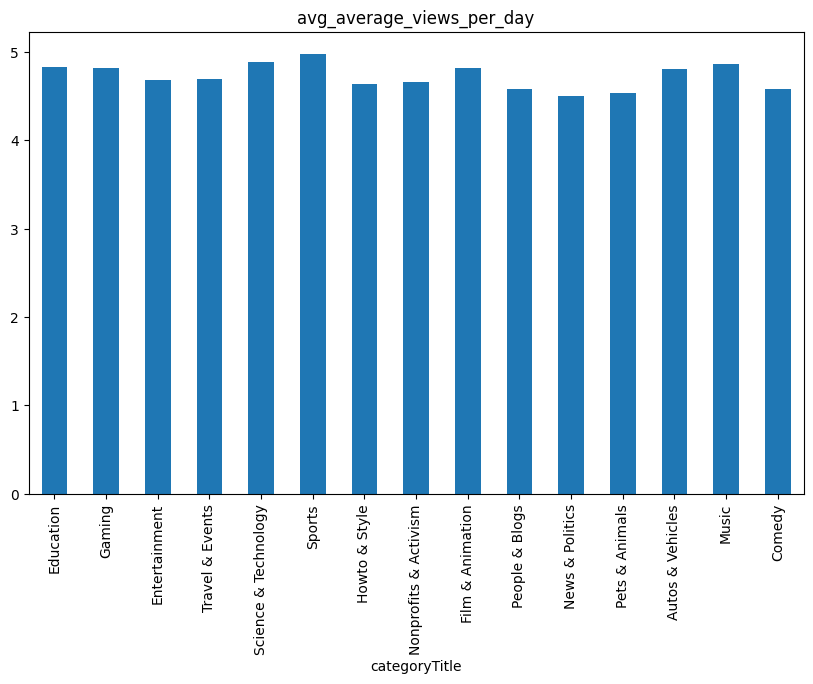

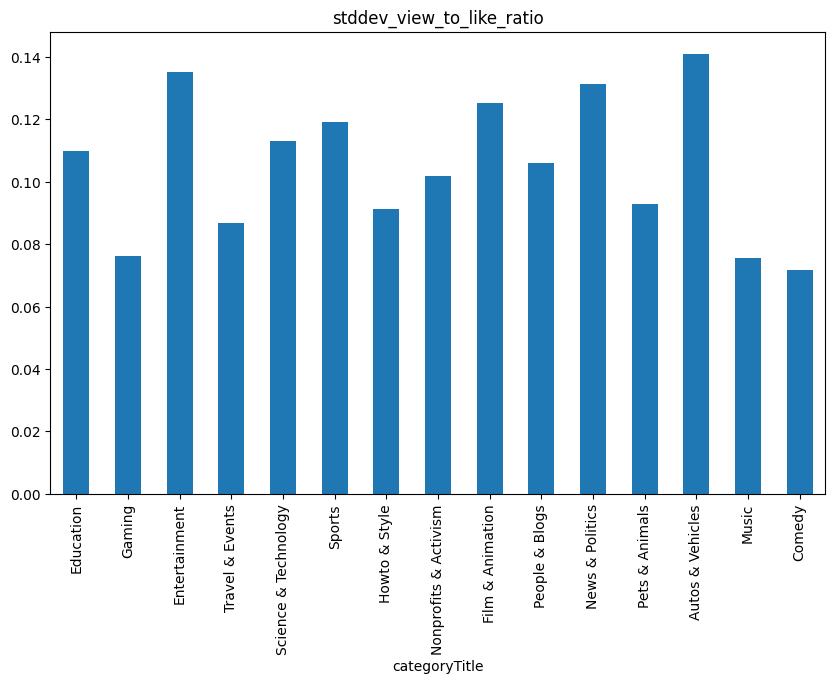

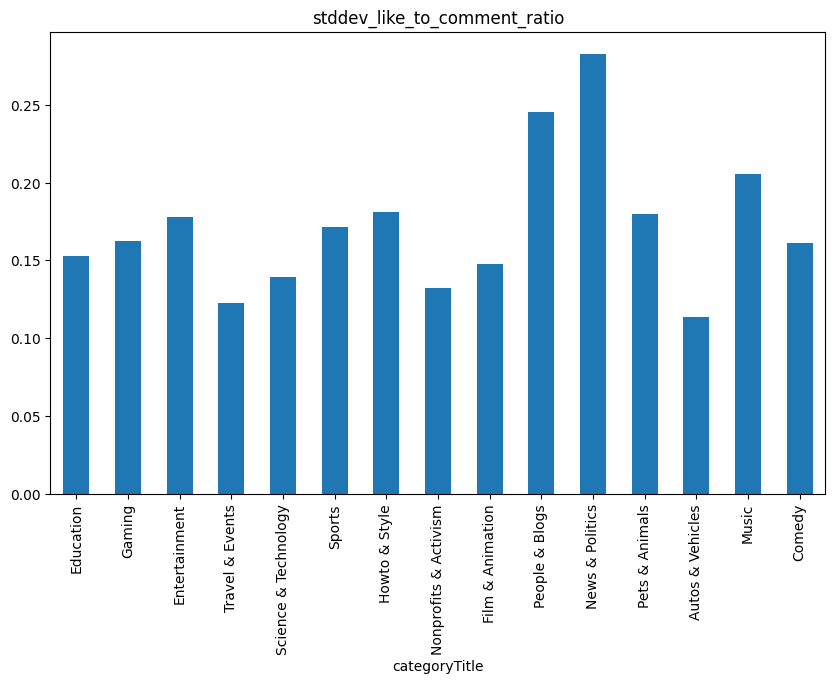

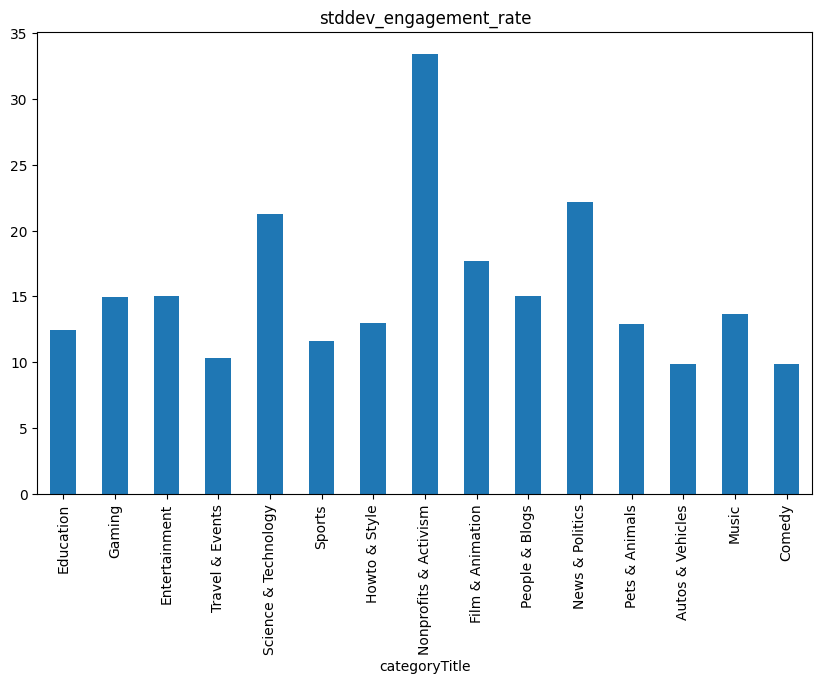

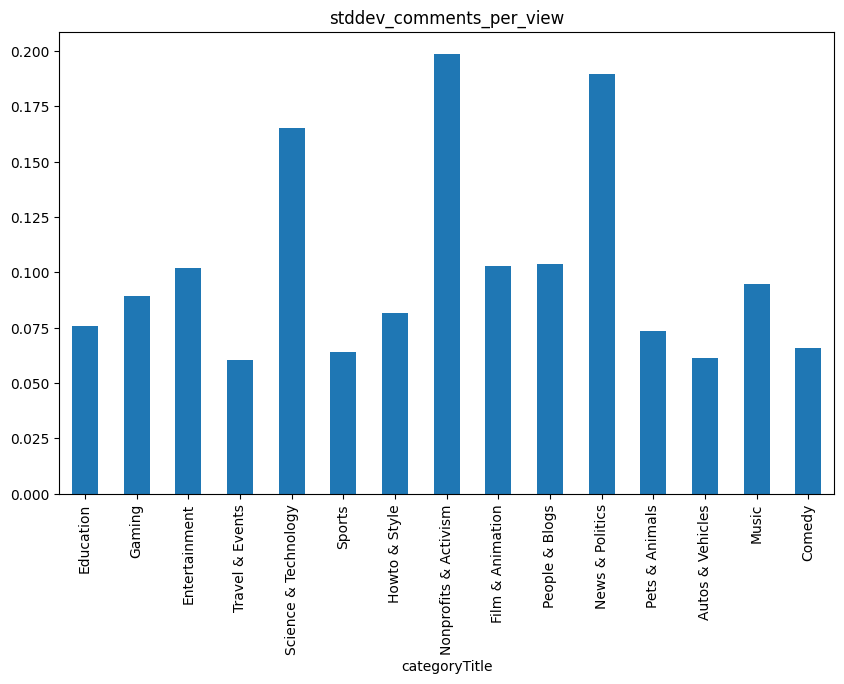

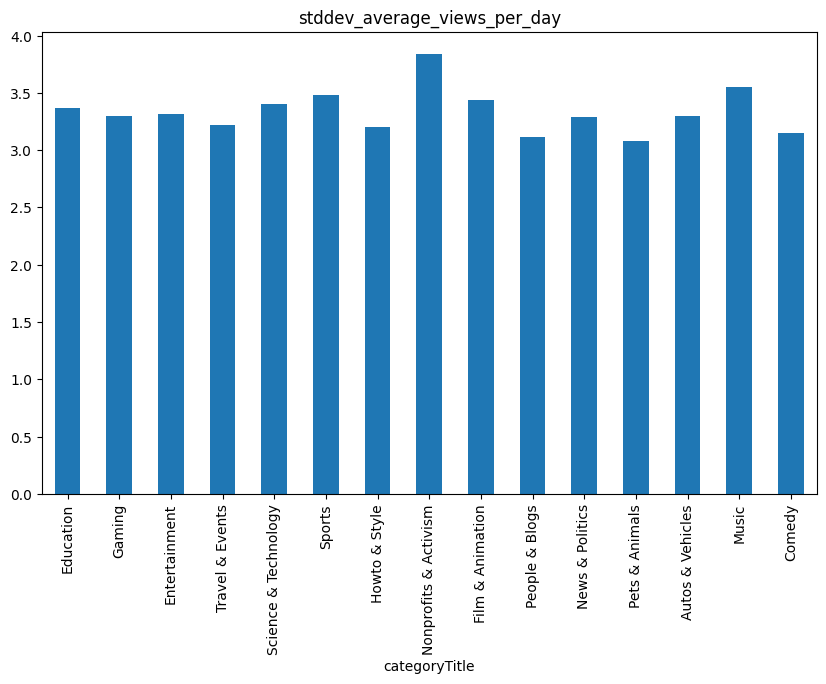

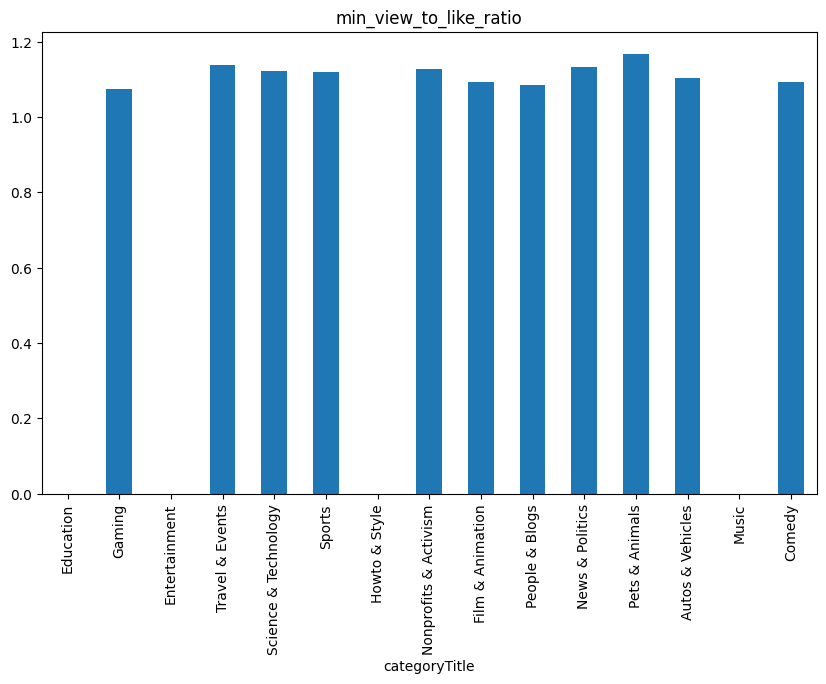

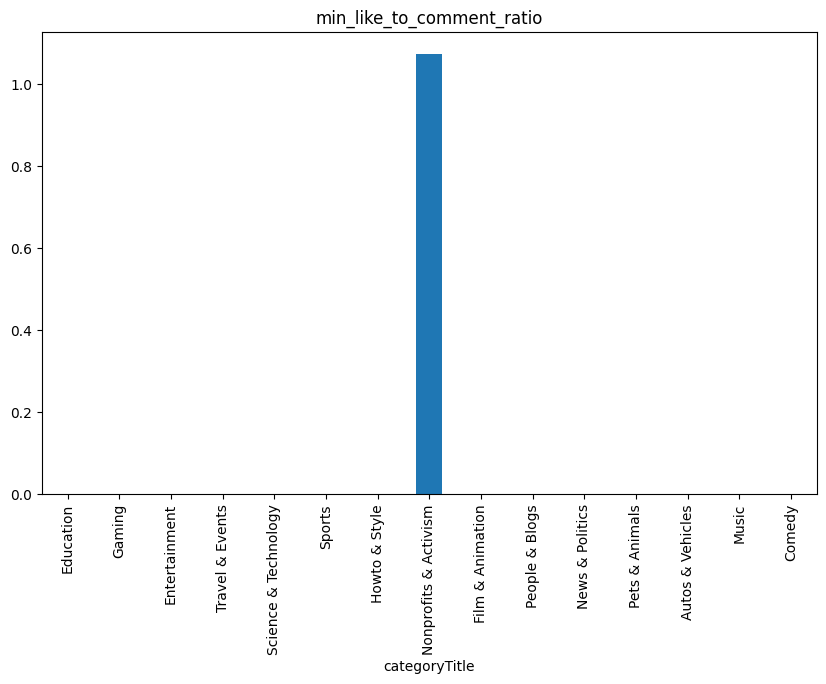

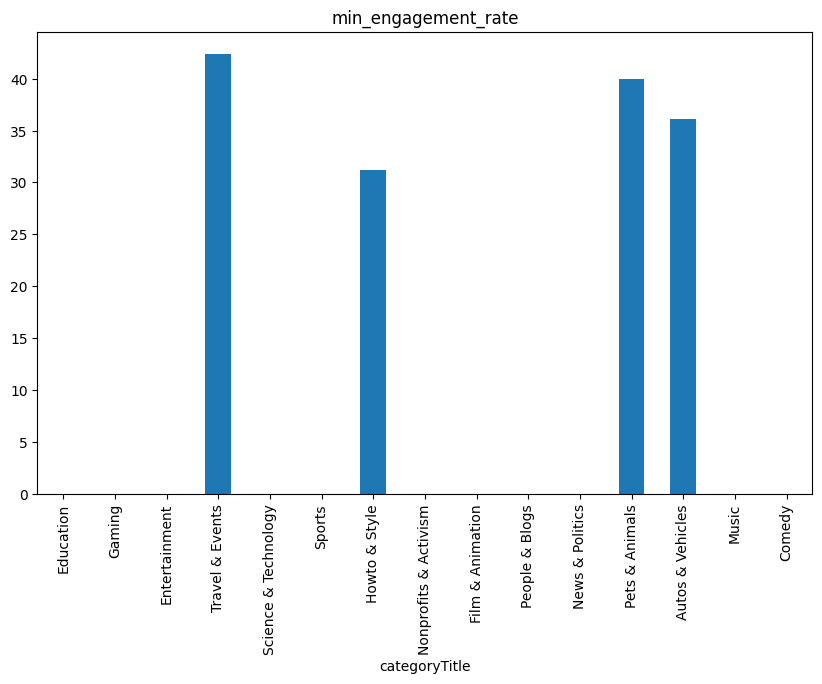

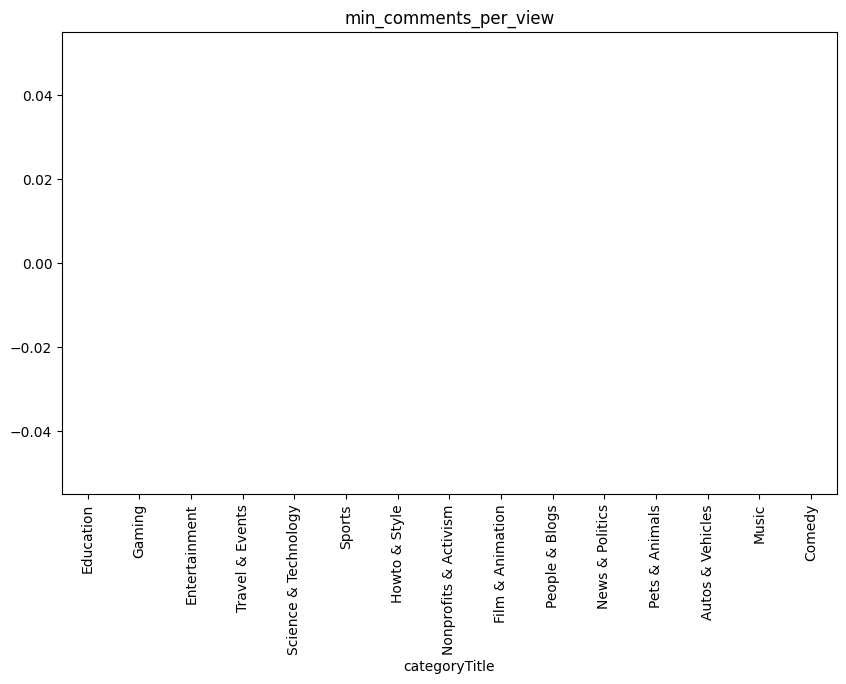

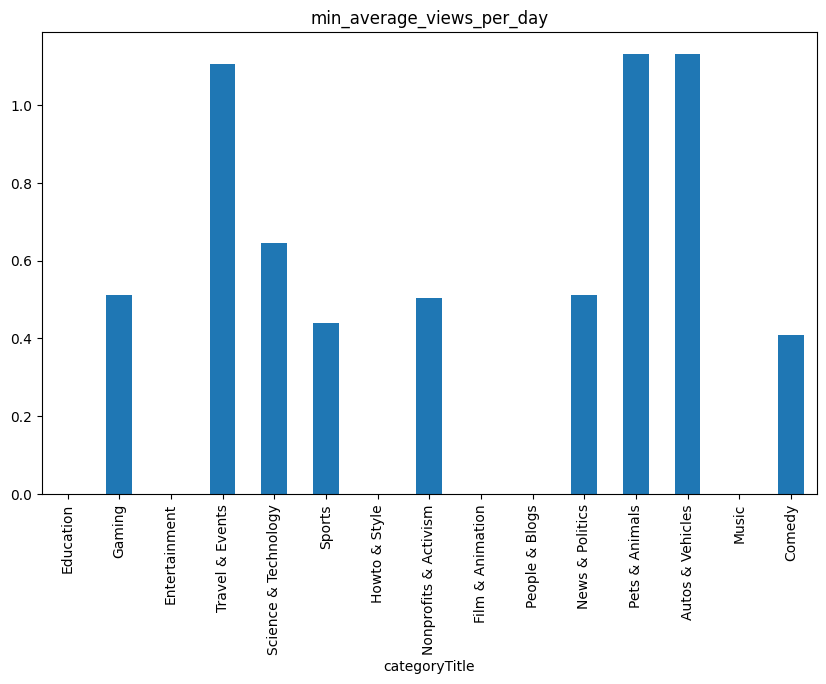

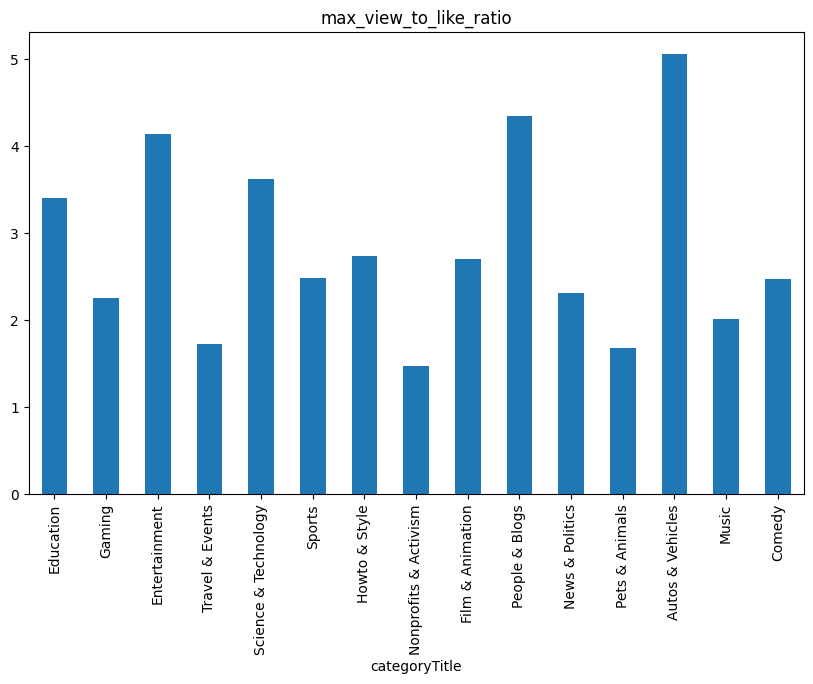

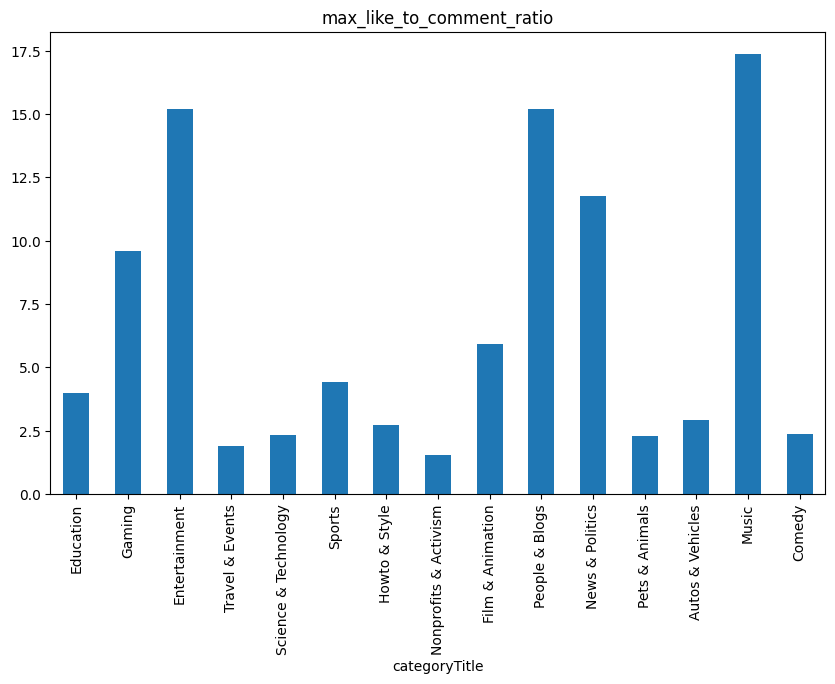

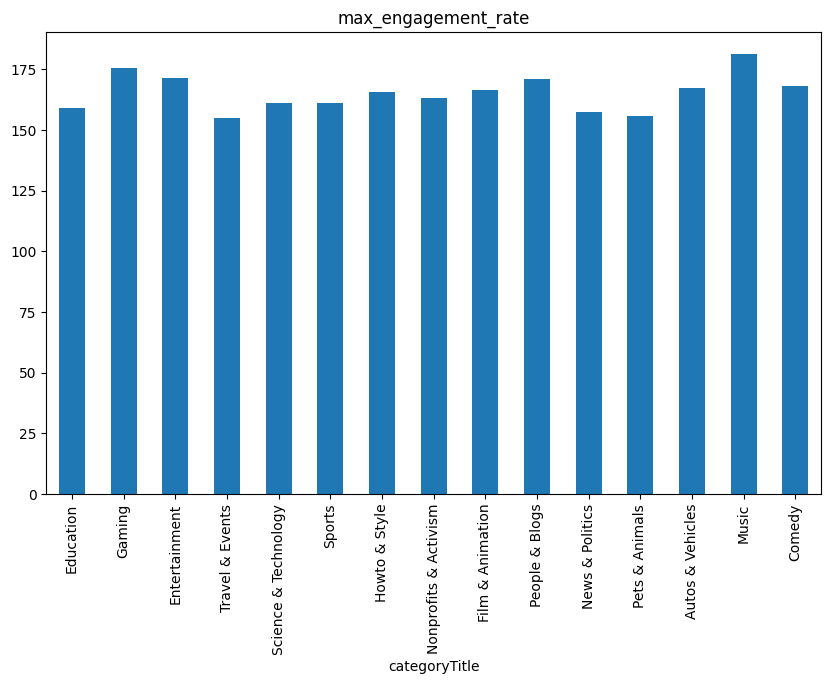

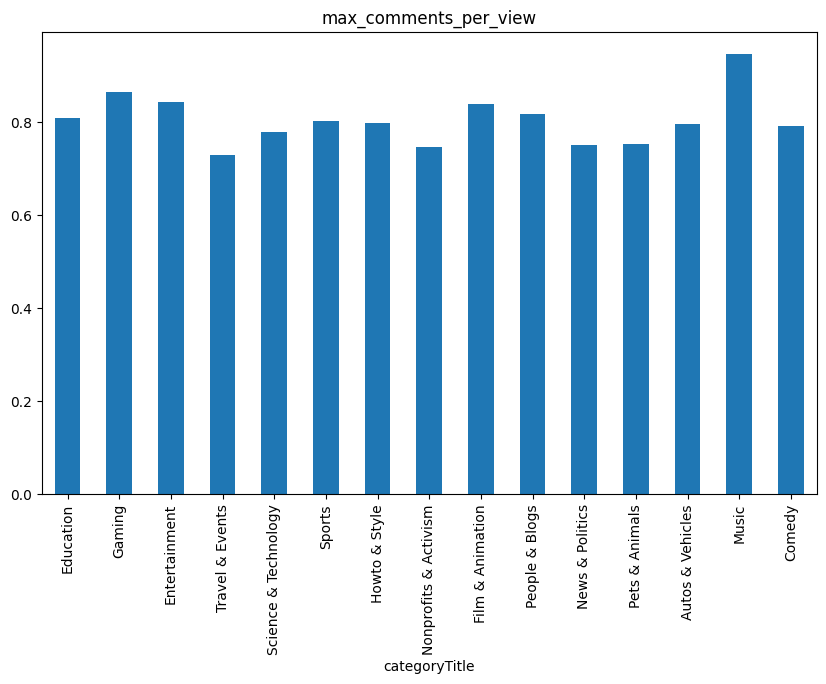

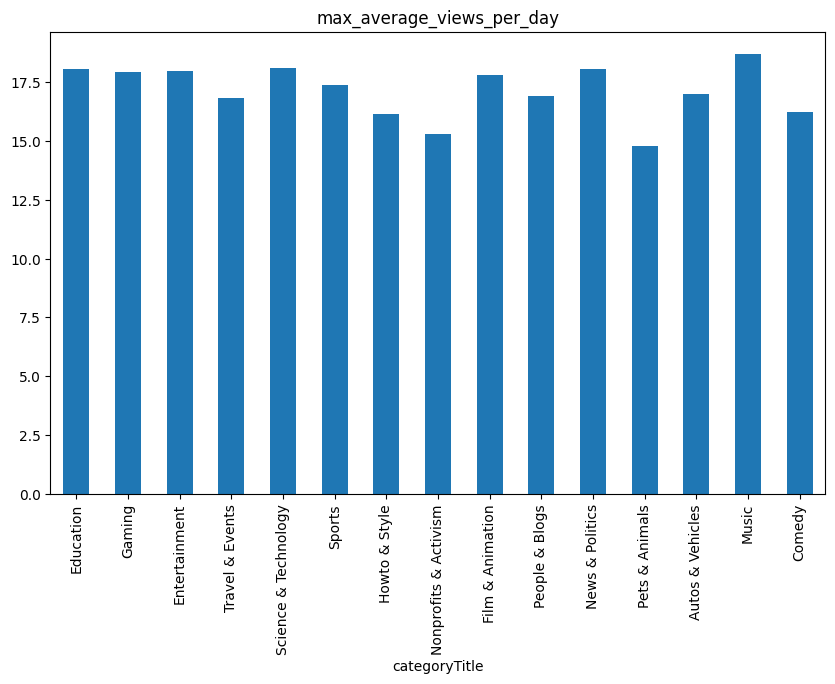

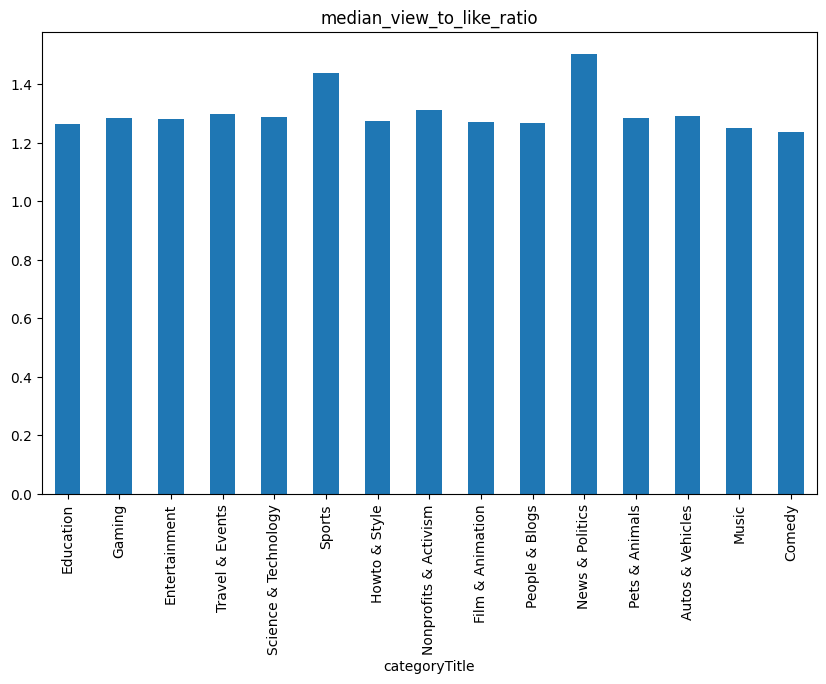

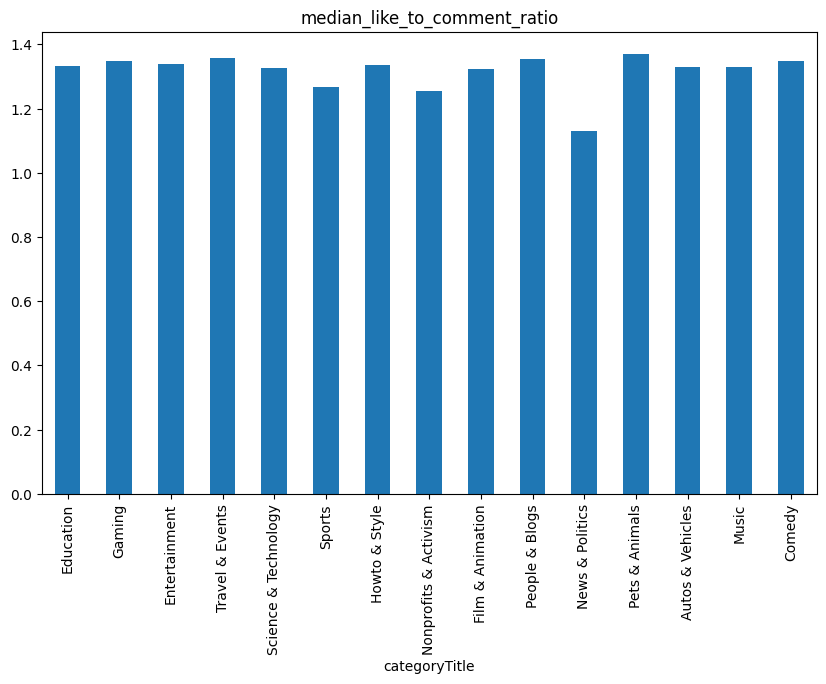

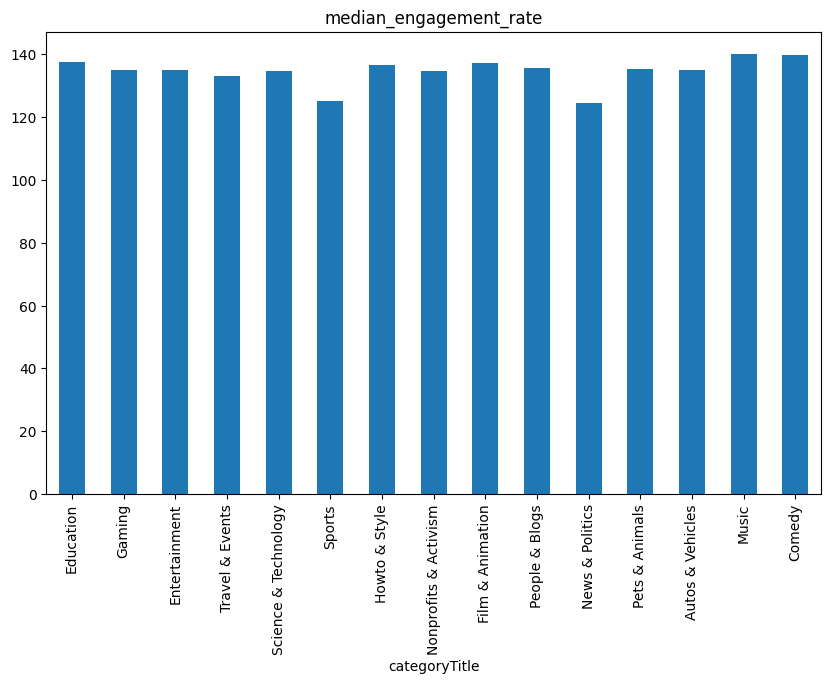

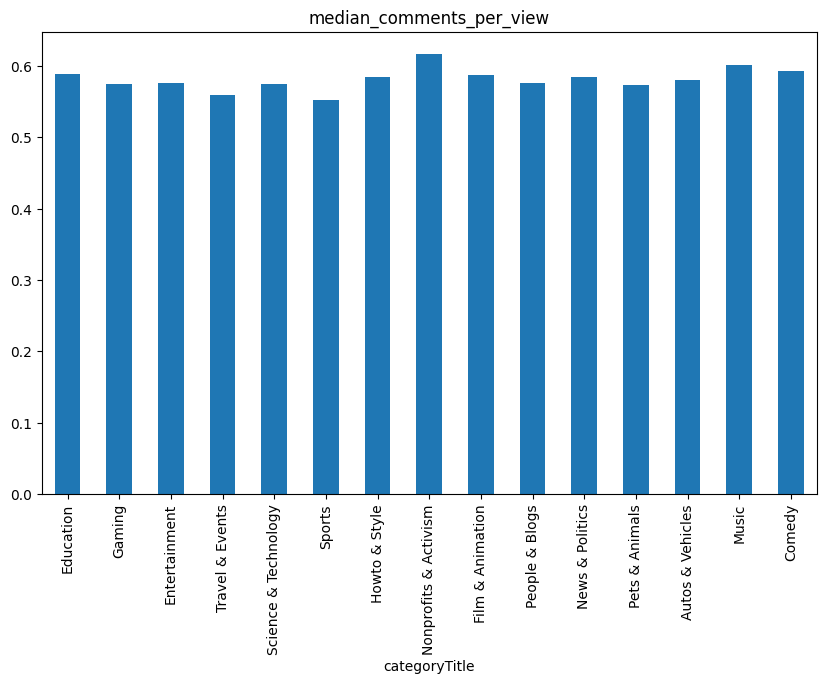

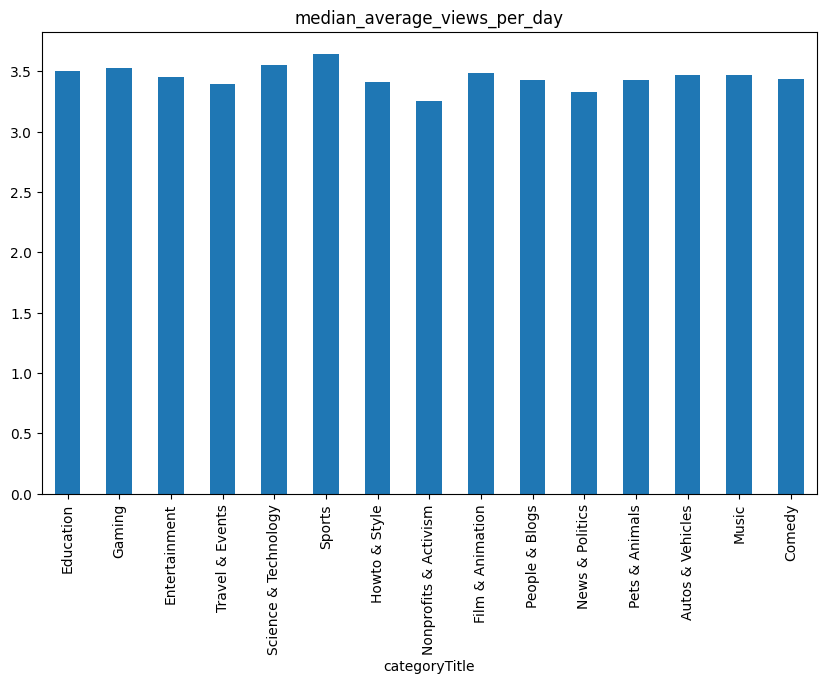

In [13]:
# graph one by one of the columns on bar chart
import matplotlib.pyplot as plt

# convert the spark dataframe to pandas dataframe
eng_metrics_by_category_pd = eng_metrics_by_category.toPandas()

def plot_bar_chart(df, column_name):
    df.plot(x='categoryTitle', y=column_name, kind='bar', figsize=(10, 6))
    plt.title(column_name)
    # hide legend
    plt.gca().get_legend().remove()
    plt.show()

for column in eng_metrics_by_category_pd.columns:
    if column != "categoryTitle":
        plot_bar_chart(eng_metrics_by_category_pd, column)

